# DATA620: Project 3 - Gender Identification

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Your project should be submitted (as an Jupyter Notebook via GitHub). The team members should all submit a link to the same repository. If any of you don't submit the link to GitHub, I will assume you didn't collaborate.
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

### Load Required Packages

In [19]:
import nltk
from nltk.corpus import names
from nltk.classify import apply_features
from nltk.probability import FreqDist
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

### Import and Lable Names

In [20]:
names = ([(name, 'male') for name in names.words('male.txt')] +
        [(name, 'female') for name in names.words('female.txt')])

random.seed(100)
random.shuffle(names)

## Data Exploration

In [21]:
# analyze data
df = pd.DataFrame(names, columns=['name','gender'])
df2 = df.groupby(['name'])['name'].count().reset_index(name='count').sort_values(['count'], ascending=False)
df2 = df2[df2['count']>1]
name_df = pd.merge(df,df2,how="inner", on=["name"])
name_df

,name,gender,count
0,Danny,male,2
1,Danny,female,2
2,Blair,female,2
3,Blair,male,2
4,Ali,male,2
...,...,...,...
725,Holly,male,2
726,Lyn,female,2
727,Lyn,male,2
728,Hilary,male,2


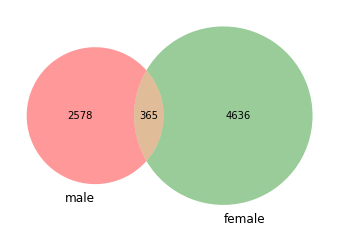

In [22]:
# Use the venn2 function
s1 = set(df[df['gender'] == 'male']['name'])
s2 = set(df[df['gender'] == 'female']['name'])
venn2([s1, s2], set_labels = ('male', 'female'))
plt.show()

In [23]:
# explore data further

df['length'] = df['name'].str.len()
df['last_letter'] = df['name'].str[-1]
df['first_letter'] = df['name'].str[0]

df['vowels'] = df['name'].str.replace(r'[^aeiou]', '')
df['vowel_last_letter'] = df['last_letter'].isin([*'aeiouy'])
df['vowel_first_letter'] = df['first_letter'].isin([*'AEIOUY'])

df['consonants'] = df['name'].str.replace(r'[aeiou]', '')
df['consonant_last_letter'] = df['last_letter'].isin([*'qwrtplkjhgfdszxcvbnm'])
df['consonant_first_letter'] = df['first_letter'].isin([*'QWRTPLKJHGFDSZXCVBNM'])

df['num_vowels'] = df['vowels'].str.len()
df['num_consonants'] = df['consonants'].str.len()

df.head()

C:\Users\ericl\anaconda3\envs\DATA620\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
C:\Users\ericl\anaconda3\envs\DATA620\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


,name,gender,length,last_letter,first_letter,vowels,vowel_last_letter,vowel_first_letter,consonants,consonant_last_letter,consonant_first_letter,num_vowels,num_consonants
0,Pembroke,male,8,e,P,eoe,True,False,Pmbrk,False,True,3,5
1,Bryant,male,6,t,B,a,False,False,Brynt,True,True,1,5
2,Pier,female,4,r,P,ie,False,False,Pr,True,True,2,2
3,Florice,female,7,e,F,oie,True,False,Flrc,False,True,3,4
4,Clint,male,5,t,C,i,False,False,Clnt,True,True,1,4


In [24]:
df.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,consonant_last_letter,consonant_first_letter,num_vowels,num_consonants
gender,,,,,,,
female,6.113777,0.804239,0.174965,0.195561,0.825035,2.475705,3.638072
male,5.895345,0.358818,0.158682,0.641182,0.841318,2.039076,3.856269


Notable differences between groups in the corpus:
* Female names tend to be longer
* Female names are much more likely to contain a vowel as the last letter
* Female names are slightly more likely to have a vowel as a first letter
* Males are much more likely to have a consonant for a last letter
* Both groups are almost equally likely to have a consonant as a first letter
* Females have more vowels on average
* Males have more consonants on average

This information provides us with a strong baseline for features to use in our gender name classifier.

### Split Corpus

In [25]:
train_names = names[1000:]
devtest_names = names[500:1000]
test_names = names[:500]

In [26]:
print('Size Train Set',len(train_names))
print('Size Development Set',len(devtest_names))
print('Size Test Set',len(test_names))

Size Train Set 6944
Size Development Set 500
Size Test Set 500


## Model Creation

We will create multiple models to see how well we can predict a person's gender based on their name.

### Model 1

This model will use the following features:
* name length
* first letter
* last letter
* first letter is a vowel
* last letter is a vowel
* number of vowels
* number of consonants

In [27]:
def gender_features1(name):
    features = {}
    features["length"] = len(name)
    features["firstLetter"] = name[0].lower()
    features["lastLetter"] = name[-1].lower()
    features["firstVowel"] = features['firstLetter'] in 'aeiouy'
    features["lastVowel"] = features['lastLetter'] in 'aeiouy'
    
    count = 0
    vowel = set("aeiouAEIOU")
    
    for i in name:
        if i in vowel:
            count = count + 1
    
    features["numVowels"] = count

    return features

gender_features1("Annie")

{'length': 5,
 'firstLetter': 'a',
 'lastLetter': 'e',
 'firstVowel': True,
 'lastVowel': True,
 'numVowels': 3}

In [28]:
train_set = apply_features(gender_features1, train_names)
devtest_set = apply_features(gender_features1, devtest_names)
test_set = apply_features(gender_features1, test_names)

#### Train Classifier

In [29]:
classifier = nltk.NaiveBayesClassifier.train(train_set) 

#### Analyze Errors 

We managed to correctly assign 76.4% of people to their gender using only their name and features derived from their name. 

Looking at the error log our model has not accounted for common ending to names (ex. Ailyn, Ashleigh, Pascale, Steve etc.). To fix this weakness in predictive power, we decided to add suffixes to our features in Model 2.

In [30]:
nltk.classify.accuracy(classifier, devtest_set)

0.764

In [31]:
errors = []
for (name, tag) in devtest_names:
    guess = classifier.classify(gender_features1(name))
    if guess != tag:
        errors.append( (tag, guess, name) ) 

In [32]:
# subset of errors (15 random errors to look to see if there is a pattern)
for (tag, guess, name) in errors[:14]: # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE 
    print ('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

correct=male     guess=female   name=Bentley                       
correct=male     guess=female   name=Slade                         
correct=female   guess=male     name=Maridel                       
correct=male     guess=female   name=Toddie                        
correct=male     guess=female   name=Morty                         
correct=female   guess=male     name=Sibel                         
correct=male     guess=female   name=Towny                         
correct=male     guess=female   name=Cy                            
correct=female   guess=male     name=Elyn                          
correct=female   guess=male     name=Tamiko                        
correct=male     guess=female   name=Percy                         
correct=male     guess=female   name=Steve                         
correct=male     guess=female   name=Nathanael                     
correct=male     guess=female   name=Alessandro                    


### Model 2

In [33]:
def gender_features2(name):
    features = {}
    features["length"] = len(name)
    features["firstLetter"] = name[0].lower()
    features["lastLetter"] = name[-1].lower()
    features["firstVowel"] = features['firstLetter'] in 'aeiouy'
    features["lastVowel"] = features['lastLetter'] in 'aeiouy'
    
    # Gets num of vowels
    count = 0
    vowel = set("aeiouAEIOU")
    
    for i in name:
        if i in vowel:
            count = count + 1
    
    features["numVowels"] = count
    features["suffix2"] = name[-2:].lower()
    features["suffix3"] = name[-3:].lower()

    return features

gender_features2("Arleen")

{'length': 6,
 'firstLetter': 'a',
 'lastLetter': 'n',
 'firstVowel': True,
 'lastVowel': False,
 'numVowels': 3,
 'suffix2': 'en',
 'suffix3': 'een'}

In [34]:
train_set = apply_features(gender_features2, train_names)
devtest_set = apply_features(gender_features2, devtest_names)
test_set = apply_features(gender_features2, test_names)

#### Train Classifier

In [35]:
classifier = nltk.NaiveBayesClassifier.train(train_set) 

#### Analyze Errors 

In [36]:
nltk.classify.accuracy(classifier, devtest_set)

0.808